In [1]:
import torch
import torch.nn as nn

from torch.autograd import Variable

import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np

import os

import matplotlib.pyplot as plt

from PIL import Image

import argparse
import sys
import traceback

In [11]:
def alpha_prior(x, alpha=2.):
    return torch.abs(x.view(-1)**alpha).sum()


def tv_norm(x, beta=2.):
    assert(x.size(0) == 1)
    img = x[0]
    dy = img - img # set size of derivative and set border = 0
    dx = img - img
    dy[:,1:,:] = -img[:,:-1,:] + img[:,1:,:]
    dx[:,:,1:] = -img[:,:,:-1] + img[:,:,1:]
    return ((dx.pow(2) + dy.pow(2)).pow(beta/2.)).sum()


def norm_loss(input, target):
    return torch.div(alpha_prior(input - target, alpha=2.), alpha_prior(target, alpha=2.))


class Denormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


class Clip(object):
    def __init__(self):
        return

    def __call__(self, tensor):
        t = tensor.clone()
        t[t>1] = 1
        t[t<0] = 0
        return t


#function to decay the learning rate
def decay_lr(optimizer, factor):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= factor 


def get_pytorch_module(net, blob):
    modules = blob.split('.')
    if len(modules) == 1:
        return net._modules.get(blob)
    else:
        curr_m = net
        for m in modules:
            curr_m = curr_m._modules.get(m)
        return curr_m


def invert(image, network = 'alexnet', size = 227, layer = 'features.4', alpha = 6, beta = 2, 
        alpha_lambda = 1e-5,  tv_lambda = 1e-5, epochs = 200, learning_rate = 1e2, 
        momentum = 0.9, decay_iter = 100, decay_factor = 1e-1, print_iter = 25, 
        cuda = False):

    mu = [0.485, 0.456, 0.406]
    sigma = [0.229, 0.224, 0.225]

    transform = transforms.Compose([
        transforms.Resize(size = size),
        transforms.CenterCrop(size = size),
        transforms.ToTensor(),
        transforms.Normalize(mu, sigma),
    ])

    detransform = transforms.Compose([
        Denormalize(mu, sigma),
        Clip(),
        transforms.ToPILImage(),
    ])

    model = models.__dict__[network](pretrained=True)
    model.eval()
    if cuda:
        model.cuda()

    img_ = transform(Image.open(image)).unsqueeze(0)
    print(img_.size())

    activations = []

    def hook_acts(module, input, output):
        activations.append(output)

    def get_acts(model, input): 
        del activations[:]
        _ = model(input)
        assert(len(activations) == 1)
        return activations[0]

    _ = get_pytorch_module(model, layer).register_forward_hook(hook_acts)
    input_var = Variable(img_.cuda() if cuda else img_) # 原始图像 x
    ref_acts = get_acts(model, input_var).detach() # f(x)

    x_ = Variable((1e-3 * torch.randn(*img_.size()).cuda() if cuda else 
        1e-3 * torch.randn(*img_.size())), requires_grad = True) # 待求解的目标


    alpha_f = lambda x: alpha_prior(x, alpha = alpha)
    tv_f = lambda x: tv_norm(x, beta = beta)
    loss_f = lambda x: norm_loss(x, ref_acts)

    optimizer = torch.optim.SGD([x_], lr = learning_rate, momentum = momentum)

    for i in range(epochs):
        acts = get_acts(model, x_)

        alpha_term = alpha_f(x_)
        tv_term = tv_f(x_)
        loss_term = loss_f(acts)

        tot_loss = alpha_lambda * alpha_term + tv_lambda * tv_term + loss_term
        
        if (i+1) % print_iter == 0:
#             print(alpha_term.data.cpu().numpy()[0])
            print('Epoch %d:\tAlpha: %f\tTV: %f\tLoss: %f\tTot Loss: %f' % (i+1,
                alpha_term.data.cpu().numpy(), tv_term.data.cpu().numpy(),
                loss_term.data.cpu().numpy(), tot_loss.data.cpu().numpy()))

        optimizer.zero_grad()
        tot_loss.backward()
        optimizer.step()

        if (i+1) % decay_iter == 0:
            decay_lr(optimizer, decay_factor)

    f, ax = plt.subplots(1,2)
    ax[0].imshow(detransform(img_[0]))
    ax[1].imshow(detransform(x_[0].data.cpu()))
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
    plt.show()

/home/fanfanda/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


torch.Size([1, 3, 227, 227])
Epoch 25:	Alpha: 967.873535	TV: 7681.877930	Loss: 0.407761	Tot Loss: 0.494258
Epoch 50:	Alpha: 1347.824951	TV: 9331.515625	Loss: 0.275926	Tot Loss: 0.382719
Epoch 75:	Alpha: 1489.729248	TV: 8523.515625	Loss: 0.250227	Tot Loss: 0.350359
Epoch 100:	Alpha: 1614.346802	TV: 8367.069336	Loss: 0.237025	Tot Loss: 0.336839
Epoch 125:	Alpha: 1623.500244	TV: 8341.781250	Loss: 0.234884	Tot Loss: 0.334537
Epoch 150:	Alpha: 1626.385986	TV: 8317.982422	Loss: 0.233960	Tot Loss: 0.333403
Epoch 175:	Alpha: 1631.384766	TV: 8299.583984	Loss: 0.233206	Tot Loss: 0.332516
Epoch 200:	Alpha: 1637.507324	TV: 8284.716797	Loss: 0.232525	Tot Loss: 0.331747


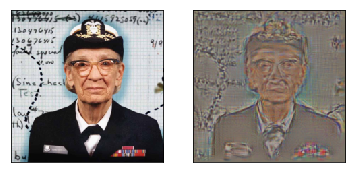

In [12]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#         print(torch.cuda.device_count(), use_mult_gpu, cuda)

invert(image = 'grace_hopper.jpg', network = 'alexnet', layer = 'features.4', 
        alpha = 6, beta = 2, alpha_lambda = 1e-5, 
        tv_lambda = 1e-5, epochs = 200,
        learning_rate = 1e2, momentum = 0.9, 
        print_iter = 25, decay_iter = 100,
        decay_factor = 1e-1, cuda = True)

In [15]:
print(1e-5 * 10000)

0.1
